#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [3]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [5]:
# !git clone https://github.com/mtzig/LIDC_GDRO.git
# %cd /content/LIDC_GDRO
# %cd ..

C:\Users\tzeng1\repos\LIDC_GDRO


import necessary libraries

In [129]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages, train_epochs

from umap import UMAP
from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [8]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Using cpu


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [25]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,split
0,836,1,0,0
1,1863,1,0,0
2,2201,0,0,0
3,1111,0,0,0
4,1894,0,0,0


First we load in the training data

In [26]:
train_data, cv_data, test_data = getImages(split=True, sublabels='malignancy', binary=True, device=DEVICE)

#datasets
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

Next we initialize the model!

In [11]:
model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

Now we train the model

In [14]:
epochs = 15
train_epochs(epochs, tr_loader, cv_loader, model, loss_fn='ERM',scheduler=True, verbose=True)

Epoch 1/15
Average training loss: 0.4948872074484825


C:\Users\tzeng1\repos\LIDC_GDRO\train.py:52: RuntimeWarning: invalid value encountered in true_divide
  subgroup_accuracy = subgroup_correct / num_samples


Accuracy: 0.8405797101449275 
Accuracy over subgroups: [       nan 0.85714286 1.         0.8       ] 
Worst Group Accuracy: nan
Epoch 2/15
Average training loss: 0.2130792558193207
Accuracy: 0.8961038961038961 
Accuracy over subgroups: [       nan 0.82352941 1.         0.95      ] 
Worst Group Accuracy: nan
Epoch 3/15
Average training loss: 0.126049941778183
Accuracy: 0.925 
Accuracy over subgroups: [       nan 0.85714286 1.         0.95555556] 
Worst Group Accuracy: nan
Epoch 4/15
Average training loss: 0.07670871168375015
Accuracy: 0.8987341772151899 
Accuracy over subgroups: [       nan 0.83870968 1.         0.93181818] 
Worst Group Accuracy: nan
Epoch 5/15
Average training loss: 0.06327462270855903
Accuracy: 0.8484848484848485 
Accuracy over subgroups: [       nan 0.68       1.         0.94594595] 
Worst Group Accuracy: nan
Epoch 6/15
Average training loss: 0.03416173886507749
Accuracy: 0.881578947368421 
Accuracy over subgroups: [       nan 0.81818182 1.         0.92105263] 
Worst

In [16]:
test(tst_loader,model)

(0.9178082191780822, nan, 0.9230769230769231, 1.0, 0.9024390243902439)

### Feature Extraction

We first save model weights (for reproducibility)

In [ ]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [20]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [29]:
noduleID, data = getImages(split=False, binary=True, device=DEVICE)

Now we extract features

In [31]:
imgs = torch.stack(data[0])
model(imgs)
img_features = activation['avgpool'].squeeze()


We collect all the features in a dataframe

In [90]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)

splits = [df_splits[df_splits['noduleID'] == id]['split'].iloc[0] for id in  df_features['noduleID']]
malig = [df_splits[df_splits['noduleID'] == id]['malignancy'].iloc[0] for id in  df_features['noduleID']]

df_features['split'] = splits
df_features['malignancy'] = malig
df_features.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,512,split,malignancy
0,101,1.391954,0.467545,1.905472,2.356219,0.040876,0.000000,0.104534,0.286290,0.178684,...,0.327227,0.327211,2.818169,0.295025,0.679386,0.949456,0.782659,1.970611,1,0
1,1017,2.339385,0.427793,1.242750,0.387758,0.000000,0.000000,0.001081,0.206466,0.537680,...,0.045685,0.000000,0.627497,0.598785,1.074713,1.183331,0.000000,1.016660,0,0
2,102,0.000000,0.252947,4.521054,3.473900,0.000000,1.004385,0.299824,0.268796,0.099110,...,0.346174,0.000000,1.888492,0.000000,0.401768,0.197017,2.101146,0.029174,0,0
3,103,0.060517,0.259883,1.832984,1.128895,0.000000,0.826544,0.027301,4.371633,0.171143,...,0.160958,0.075954,2.260294,0.000000,0.609978,1.078527,3.761819,0.247361,0,0
4,104,0.260390,0.000000,0.000000,2.491910,0.016017,3.531558,2.025470,3.758451,0.078662,...,0.197781,0.155870,2.284213,0.000000,0.834848,4.143511,2.039289,0.651699,0,0


We again save the data for reproducibility

In [78]:
df_features.to_csv('./data/erm_cluster_cnn_features.csv')

## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [140]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [141]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [142]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [143]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

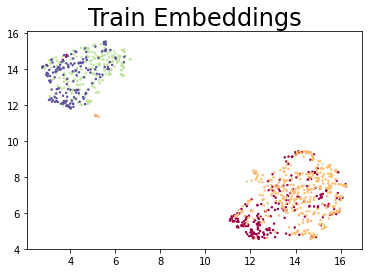

In [144]:
plt.scatter(train_embeds[:, 0], train_embeds[:, 1], s= 2, c=df_features_train['malignancy'], cmap='Spectral')
plt.title('Train Embeddings', fontsize=24);


We also do same visualization on cv and test

In [145]:
cv_test_embeds = reducer.transform(cv_test_features)

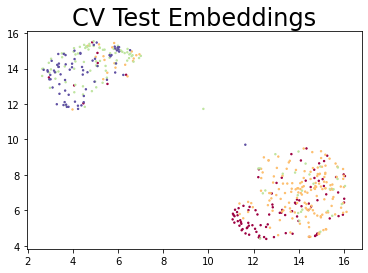

In [146]:
plt.scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1], s= 2, c=df_features_cv_test['malignancy'], cmap='Spectral')
plt.title('CV Test Embeddings', fontsize=24);

We now save the reduce

In [147]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

Text(0, 0.5, 'Silhouette Coefficients')

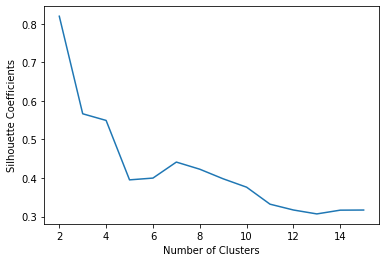

In [148]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds)
  labels = gmm.predict(train_embeds)
  
  silhouette_avg = silhouette_score(train_embeds, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2. But as subclass of 4 still gives decent scores (before big drop), we will use that.

In [149]:
clusterer = GaussianMixture(n_components=4, random_state=61).fit(train_embeds)

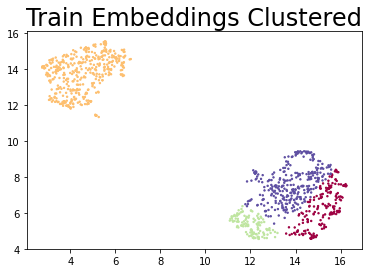

In [150]:
train_labels = clusterer.predict(train_embeds)

plt.scatter(train_embeds[:, 0], train_embeds[:, 1], s= 2, c=train_labels, cmap='Spectral')
plt.title('Train Embeddings Clustered', fontsize=24);

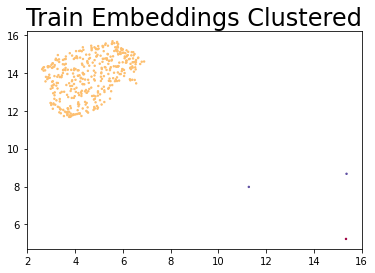

In [154]:
features = df_features_train[df_features_train['malignancy']>1].drop(['noduleID', 'split', 'malignancy'], axis=1).values
embeds = reducer.transform(features)
labels = clusterer.predict(embeds)

plt.scatter(embeds[:, 0], embeds[:, 1], s= 2, c=labels, cmap='Spectral')
plt.title('Train Embeddings Clustered', fontsize=24);